In [2]:
from pathlib import Path

import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
import torch
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps

from data import load_algonauts2025_movie10_fmri
from utils import pearsonr_score
from surface_utils import FlatResampler, load_flat, extract_valid_flat

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
ROOT = Path("/home/connor/algonauts2025.clean")
print(ROOT)

SUBJECTS = (1, 2, 3, 5)

PIXEL_SIZE = 1.2
RECT = (-330.0, 330.0, -150.0, 160.0)

/home/connor/algonauts2025.clean


In [4]:
plt.style.use("clane.mplstyle")
plt.rcParams["figure.dpi"] = 350
PLOTW = 3.5

In [5]:
def load_resampler_parc() -> tuple[FlatResampler, np.ndarray]:
    parc = nib.load(ROOT / "Schaefer2018_1000Parcels_7Networks_order.dlabel.nii")
    parc = parc.get_fdata().squeeze().astype(np.int32)

    mask = parc > 0
    flat = load_flat("32k_fs_LR")
    flat, mask = extract_valid_flat(flat, mask)

    resampler = FlatResampler(pixel_size=PIXEL_SIZE, rect=RECT)
    resampler.fit(flat)

    parc_flat = resampler.transform(parc[mask], interpolation="nearest")

    N, P = int(resampler.mask_.sum()), int(parc.max())
    parc_one_hot = np.zeros((N, P))
    parc_indices = parc_flat[resampler.mask_].astype(np.int64) - 1
    parc_one_hot[np.arange(N), parc_indices] = 1.0
    return resampler, parc_one_hot

In [6]:
def map_to_flat(
    resampler: FlatResampler,
    parc_one_hot: np.ndarray,
    data: np.ndarray,
):
    assert data.ndim == 1
    H, W = resampler.mask_.shape
    flat_data = np.full((H, W), fill_value=np.nan, dtype=data.dtype)
    flat_data[resampler.mask_] = parc_one_hot @ data
    return flat_data

In [7]:
resampler, parc_one_hot = load_resampler_parc()

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [8]:
feat_enc_ckpt_path = ROOT / "output/feature_encoding_default_2507211453/ckpt.pt"
feat_enc_ckpt = torch.load(feat_enc_ckpt_path, map_location="cpu", weights_only=False)
feat_enc_metrics = feat_enc_ckpt["metrics"]

In [9]:
cross_enc_ckpt_path = ROOT / "output/cross_encoding_default_2507211453/ckpt.pt"
cross_enc_ckpt = torch.load(cross_enc_ckpt_path, map_location="cpu", weights_only=False)
cross_enc_metrics = cross_enc_ckpt["metrics"]

In [10]:
fmri_figures = load_algonauts2025_movie10_fmri(
    root=ROOT / "datasets/algonauts_2025.competitors",
    movies=["figures"],
)

fmri_life = load_algonauts2025_movie10_fmri(
    root=ROOT / "datasets/algonauts_2025.competitors",
    movies=["life"],
)

In [11]:
figures_episodes = sorted({episode for episode, run in fmri_figures})
life_episodes = sorted({episode for episode, run in fmri_life})

In [12]:
fmri_figures_1 = np.concatenate(
    [fmri_figures[(episode, 1)] for episode in figures_episodes],
    axis=1,
)
fmri_figures_2 = np.concatenate(
    [fmri_figures[(episode, 2)] for episode in figures_episodes],
    axis=1,
)
fmri_life_1 = np.concatenate(
    [fmri_life[(episode, 1)] for episode in life_episodes],
    axis=1,
)
fmri_life_2 = np.concatenate(
    [fmri_life[(episode, 2)] for episode in life_episodes],
    axis=1,
)

In [13]:
print(fmri_figures_1.shape, fmri_figures_2.shape)
print(fmri_life_1.shape, fmri_life_2.shape)

(4, 4863, 1000) (4, 4863, 1000)
(4, 2008, 1000) (4, 2008, 1000)


In [14]:
def score_predictions(samples: np.ndarray, preds: np.ndarray):
    metrics = {}
    acc = 0.0
    acc_map = np.zeros(samples.shape[-1])
    for ii, sub in enumerate(SUBJECTS):
        y_true = samples[ii]
        y_pred = preds[ii]
        metrics[f"accmap_sub-{sub}"] = acc_map_i = pearsonr_score(y_true, y_pred)
        metrics[f"acc_sub-{sub}"] = acc_i = np.mean(acc_map_i)
        acc_map += acc_map_i / len(SUBJECTS)
        acc += acc_i / len(SUBJECTS)
    metrics["accmap_avg"] = acc_map
    metrics["acc_avg"] = acc
    return acc, metrics

In [15]:
nc_metrics = {}
nc_acc_figures, nc_metrics["val_figures"] = score_predictions(
    fmri_figures_1, fmri_figures_2
)
nc_acc_life, nc_metrics["val_life"] = score_predictions(fmri_life_1, fmri_life_2)
print(f"figures noise ceiling: {nc_acc_figures:.3f}")
print(f"life noise ceiling: {nc_acc_life:.3f}")

figures noise ceiling: 0.230
life noise ceiling: 0.161


second version of noise ceiling

In [19]:
def estimate_noise_ceiling(data: np.ndarray, eps: float = 1e-8):
    """
    data: (repeats, timepoints, voxels)

    reference:
    https://github.com/HuthLab/encoding-model-scaling-laws/blob/main/Scaling_Law_Tutorial.ipynb
    https://www.frontiersin.org/journals/computational-neuroscience/articles/10.3389/fncom.2016.00010/full

    Nb, I don't really understand this, and the estimates are very inflated.
    """
    N = len(data)
    TP = np.sum(np.var(data, axis=1, ddof=1), axis=0)
    SP = np.var(np.sum(data, axis=0), axis=0, ddof=1) - TP
    SP = np.clip(SP, eps, None)
    CC_max = 1 / np.sqrt(1 + ((1 / N) * ((N - 1) * TP / SP - 1)))
    # TP = np.mean(np.var(data, axis=1, ddof=1), axis=0)
    # SP = np.clip((1 / (N-1)) * ((N * np.var(y, axis=0, ddof=1)) - TP), eps, None)
    # NP = np.clip(TP - SP, 0, None)
    # CC_max = 1 / np.sqrt(1 + ((1/N) * (NP/SP)))
    return CC_max

In [20]:
def score_predictions_v2(samples: np.ndarray, preds: np.ndarray):
    metrics = {}
    acc = 0.0
    acc_map = np.zeros(samples.shape[-1])
    for ii, sub in enumerate(SUBJECTS):
        data = np.stack([samples[ii], preds[ii]])
        metrics[f"accmap_sub-{sub}"] = acc_map_i = estimate_noise_ceiling(data)
        metrics[f"acc_sub-{sub}"] = acc_i = np.mean(acc_map_i)
        acc_map += acc_map_i / len(SUBJECTS)
        acc += acc_i / len(SUBJECTS)
    metrics["accmap_avg"] = acc_map
    metrics["acc_avg"] = acc
    return acc, metrics

In [21]:
nc_metrics_v2 = {}
nc_acc_figures_v2, nc_metrics_v2["val_figures"] = score_predictions_v2(
    fmri_figures_1, fmri_figures_2
)
nc_acc_life_v2, nc_metrics_v2["val_life"] = score_predictions_v2(
    fmri_life_1, fmri_life_2
)
print(f"figures noise ceiling v2 : {nc_acc_figures_v2:.3f}")
print(f"life noise ceiling: {nc_acc_life_v2:.3f}")

figures noise ceiling v2 : 0.567
life noise ceiling: 0.468


In [32]:
schaefer_flat_masks = np.load("schaefer_flat_masks.npz")
default_boundary_flat = schaefer_flat_masks["default_boundary_flat"]
vis_boundary_flat = schaefer_flat_masks["vis_boundary_flat"]
# schaefer_boundary_flat = default_boundary_flat | vis_boundary_flat
schaefer_boundary_flat = default_boundary_flat
resampler.mask_.shape, schaefer_boundary_flat.shape

((258, 550), (258, 550))

In [36]:
def plot_ceil_comparison(split: str = "val_figures"):
    H, W = resampler.mask_.shape

    # (abs, rel) x (nc, cross)
    nr = 2
    nc = 2
    plotw = 2 * PLOTW / 3
    ploth = 1.2 * H / W * plotw

    f, axs = plt.subplots(nr, nc, figsize=(nc * plotw, nr * ploth))

    vmax = 0.7
    vmin = -vmax
    rel_vmax = 0.15
    rel_vmin = -rel_vmax
    cmap = nilearn_cmaps["cold_white_hot"]
    cmap.set_bad("lightgray")

    titles = np.array(
        [
            ["Test-retest noise ceiling", "Cross-subject encoding"],
            [
                "Feature encoding $-$ noise ceiling",
                "Feature encoding $-$ cross-sub encoding",
            ],
        ]
    )

    for jj, metrics in enumerate([nc_metrics_v2, cross_enc_metrics]):
        ax = axs[0, jj]
        plt.sca(ax)
        accmap = metrics[split]["accmap_avg"]
        mean_acc = accmap.mean()
        accmap_flat = map_to_flat(resampler, parc_one_hot, accmap)
        img1 = plt.imshow(
            accmap_flat, cmap=cmap, interpolation="none", vmin=vmin, vmax=vmax
        )
        plt.imshow(
            np.where(schaefer_boundary_flat, 0.0, np.nan),
            cmap="gray",
            interpolation="none",
            vmin=0,
            vmax=1,
        )
        plt.text(
            0.02,
            0.98,
            f"$r$={mean_acc:.3f}",
            ha="left",
            va="top",
            fontsize=5,
            transform=ax.transAxes,
        )
        plt.xticks([])
        plt.yticks([])
        plt.title(titles[0, jj], fontsize=7)

        ax = axs[1, jj]
        plt.sca(ax)
        accmap = feat_enc_metrics[split]["accmap_avg"] - metrics[split]["accmap_avg"]
        mean_acc = accmap.mean()
        accmap_flat = map_to_flat(resampler, parc_one_hot, accmap)
        img2 = plt.imshow(
            accmap_flat, cmap=cmap, interpolation="none", vmin=rel_vmin, vmax=rel_vmax
        )
        plt.imshow(
            np.where(schaefer_boundary_flat, 0.0, np.nan),
            cmap="gray",
            interpolation="none",
            vmin=0,
            vmax=1,
        )
        plt.text(
            0.02,
            0.98,
            f"$r$={mean_acc:.3f}",
            ha="left",
            va="top",
            fontsize=5,
            transform=ax.transAxes,
        )
        plt.xticks([])
        plt.yticks([])
        plt.title(titles[1, jj], fontsize=7)

    plt.tight_layout()

    ax = axs[0, 1]
    axins = inset_axes(
        ax,
        width="33%",
        height="5%",
        loc="lower right",
        bbox_to_anchor=(0, 0.08, 0.98, 1),  # (l, b, w, h)
        bbox_transform=ax.transAxes,
    )
    axins.xaxis.set_ticks_position("bottom")
    cbar = f.colorbar(img1, cax=axins, orientation="horizontal")
    cbar.ax.set_xlim([-0.2, vmax])
    cbar.ax.set_xticks([0.0, 0.3, 0.7])
    cbar.ax.tick_params(labelsize=5)

    ax = axs[1, 1]
    axins = inset_axes(
        ax,
        width="33%",
        height="5%",
        loc="lower right",
        bbox_to_anchor=(0, 0.08, 0.98, 1),  # (l, b, w, h)
        bbox_transform=ax.transAxes,
    )
    axins.xaxis.set_ticks_position("bottom")
    cbar = f.colorbar(img2, cax=axins, orientation="horizontal")
    cbar.ax.set_xlim([-rel_vmax, rel_vmax])
    cbar.ax.set_xticks([-rel_vmax, 0, rel_vmax])
    cbar.ax.tick_params(labelsize=5)

    return f

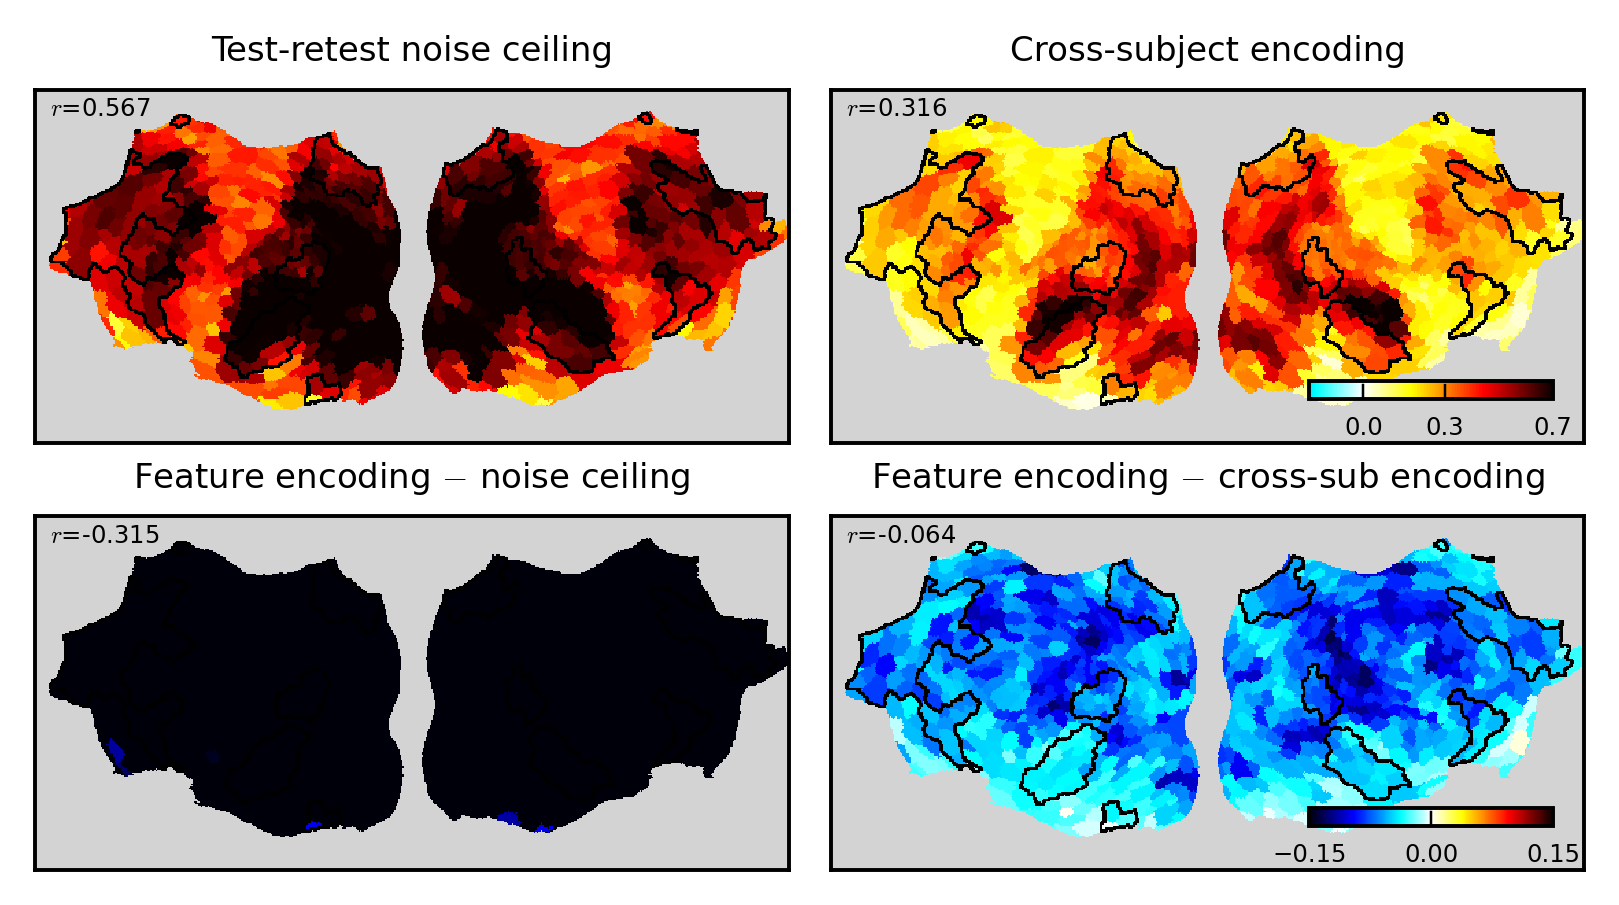

In [37]:
f = plot_ceil_comparison("val_figures")
# f.savefig("output/noise_ceiling_comparison_figures.png", bbox_inches="tight")

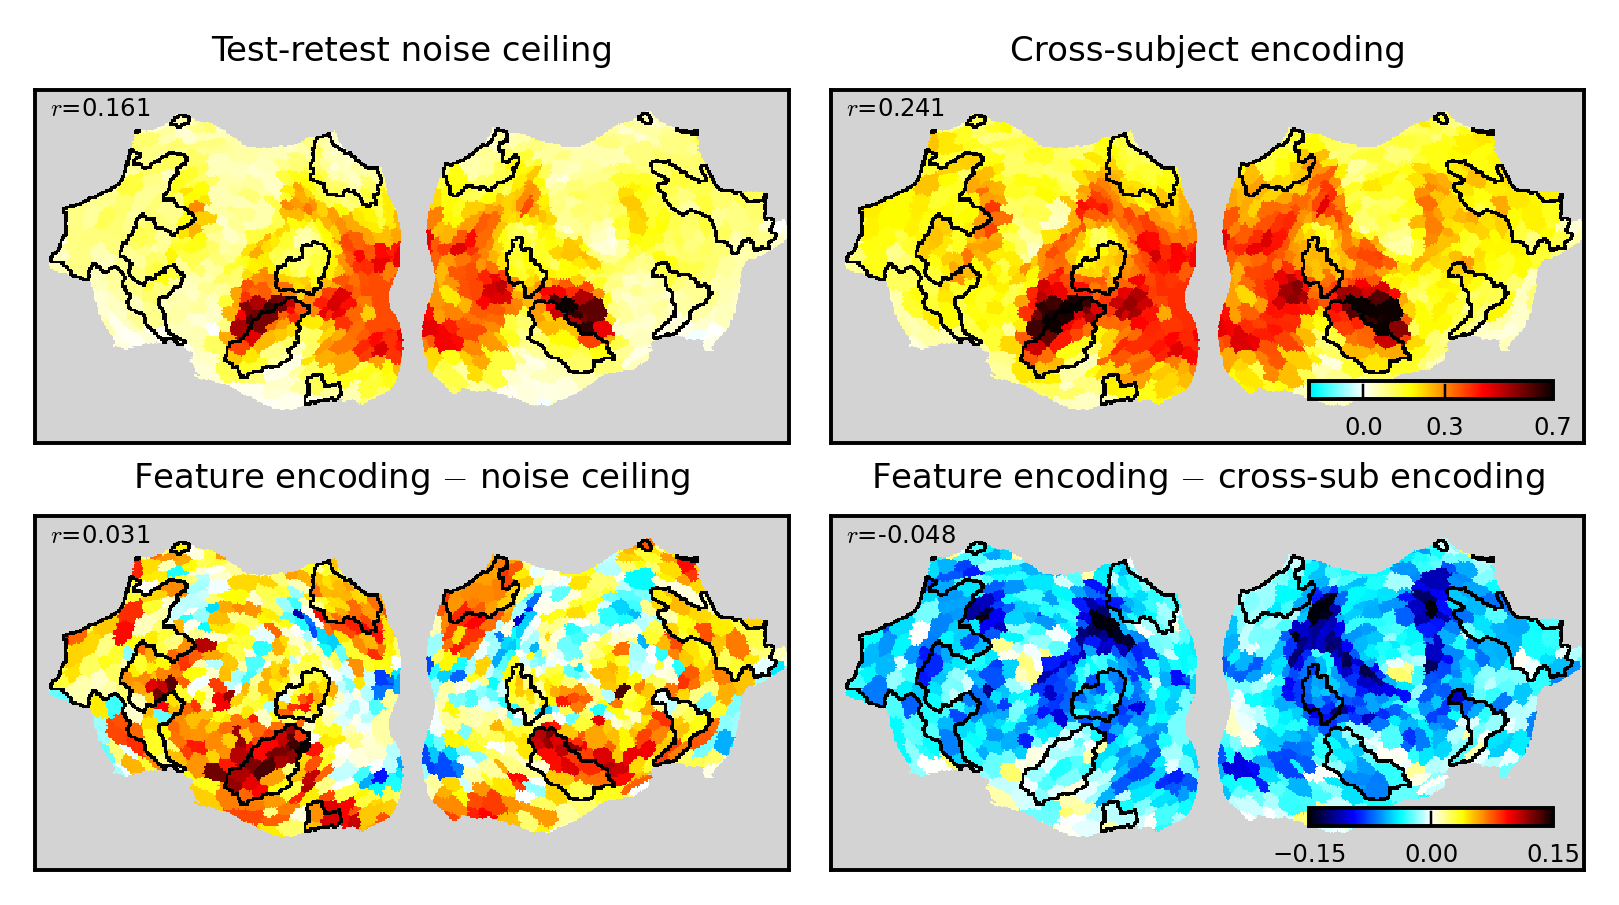

In [35]:
f = plot_ceil_comparison("val_life")
# f.savefig("output/noise_ceiling_comparison_life.png", bbox_inches="tight")